In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [9]:
### read data

data = pd.read_csv("~/Downloads/license_plates_acution_data.csv",usecols=["Date",
                                                                          "num_bidder",
                                                                          "num_plates",
                                                                          "lowest_deal_price",
                                                                          "avg_deal_price"],dtype={
    "Date":"str",
    "num_bidder":"float",
    "num_plates":"float",
    "lowest_deal_price":"float",
    "avg_deal_price":"float"
})

In [10]:
data.head()

,Date,avg_deal_price,lowest_deal_price,num_bidder,num_plates
0,2002.1,14735.0,13600.0,3718.0,1400.0
1,2002.2,14057.0,13100.0,4590.0,1800.0
2,2002.3,14662.0,14300.0,5190.0,2000.0
3,2002.4,16334.0,16000.0,4806.0,2300.0
4,2002.5,18357.0,17800.0,4665.0,2350.0


In [11]:
### set date to be index
data["Date"] = pd.to_datetime(data["Date"])

In [12]:
data.set_index("Date",inplace=True)

In [13]:
data.head()

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
Date,,,,
2002-01-01,14735.0,13600.0,3718.0,1400.0
2002-02-01,14057.0,13100.0,4590.0,1800.0
2002-03-01,14662.0,14300.0,5190.0,2000.0
2002-04-01,16334.0,16000.0,4806.0,2300.0
2002-05-01,18357.0,17800.0,4665.0,2350.0


In [16]:
# check for missing values
for y in range(2002,2018):
    print(y,"\t\t", data[str(y)].shape)

2002 		 (12, 4)
2003 		 (12, 4)
2004 		 (12, 4)
2005 		 (12, 4)
2006 		 (12, 4)
2007 		 (12, 4)
2008 		 (11, 4)
2009 		 (12, 4)
2010 		 (12, 4)
2011 		 (12, 4)
2012 		 (12, 4)
2013 		 (12, 4)
2014 		 (12, 4)
2015 		 (12, 4)
2016 		 (12, 4)
2017 		 (10, 4)


In [17]:
data["2008"]

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
Date,,,,
2008-01-01,23370.0,8100.0,20539.0,16000.0
2008-03-01,32169.0,31300.0,63534.0,9300.0
2008-04-01,37659.0,37300.0,37072.0,9000.0
2008-05-01,36047.0,34400.0,26341.0,8200.0
2008-06-01,34947.0,33900.0,21208.0,7700.0
2008-07-01,34491.0,33800.0,16783.0,6800.0
2008-08-01,36460.0,35900.0,13451.0,6000.0
2008-09-01,31788.0,29300.0,11002.0,6500.0
2008-10-01,33224.0,32600.0,11882.0,5000.0


In [19]:
## fill missing value with mean of each col
mean_2008 = data["2008"].mean(axis=0)
mean_2008

avg_deal_price       32379.181818
lowest_deal_price    29945.454545
num_bidder           22616.636364
num_plates            7681.818182
dtype: float64

In [24]:
feb_2008 = pd.DataFrame([mean_2008],index=[pd.to_datetime("2008-02-01")],columns=data.columns)


In [26]:
# insert row into dataframe
data = pd.concat([data,feb_2008])
data.sort_index(inplace=True)
data["2008"]

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2008-01-01,23370.000000,8100.000000,20539.000000,16000.000000
2008-02-01,32379.181818,29945.454545,22616.636364,7681.818182
2008-03-01,32169.000000,31300.000000,63534.000000,9300.000000
2008-04-01,37659.000000,37300.000000,37072.000000,9000.000000
2008-05-01,36047.000000,34400.000000,26341.000000,8200.000000
2008-06-01,34947.000000,33900.000000,21208.000000,7700.000000
2008-07-01,34491.000000,33800.000000,16783.000000,6800.000000
2008-08-01,36460.000000,35900.000000,13451.000000,6000.000000
2008-09-01,31788.000000,29300.000000,11002.000000,6500.000000
2008-10-01,33224.000000,32600.000000,11882.000000,5000.000000


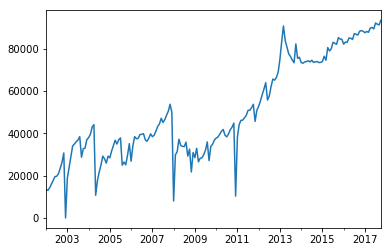

In [27]:
#### check stationarity of data by plotting, we are interested in predicting the lowest_deal_price
data["lowest_deal_price"].plot()

In [31]:
## apprently data is not stationary and fluctuating with clear trend going upwards, and probably some seasonal effects
## Also there are some outliers around 2003,2008,2011 that need to be taken care of
data["2010"]

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2010-01-01,38311.0,37800.0,18975.0,8000.0
2010-02-01,38620.0,38300.0,18810.0,7500.0
2010-03-01,39882.0,39600.0,17704.0,8000.0
2010-04-01,41637.0,41000.0,17313.0,8500.0
2010-05-01,42262.0,41900.0,16324.0,8500.0
2010-06-01,40380.0,39200.0,16252.0,9200.0
2010-07-01,39362.0,38400.0,13389.0,9000.0
2010-08-01,40169.0,39800.0,16855.0,9000.0
2010-09-01,42180.0,41800.0,15198.0,9000.0
2010-10-01,43271.0,43000.0,14941.0,9000.0


In [30]:
## we need to replace that peculiar 100 by replacing it with mean of 2002

data.set_value("2002-12-01","lowest_deal_price",data["2002"]["lowest_deal_price"].mean(axis=0))
data["2002"]

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2002-01-01,14735.0,13600.000000,3718.0,1400.0
2002-02-01,14057.0,13100.000000,4590.0,1800.0
2002-03-01,14662.0,14300.000000,5190.0,2000.0
2002-04-01,16334.0,16000.000000,4806.0,2300.0
2002-05-01,18357.0,17800.000000,4665.0,2350.0
2002-06-01,20178.0,19600.000000,4502.0,2800.0
2002-07-01,20904.0,19800.000000,3774.0,3000.0
2002-08-01,21601.0,21000.000000,4640.0,3000.0
2002-09-01,24040.0,23600.000000,4393.0,3200.0
2002-10-01,27040.0,26400.000000,4661.0,3200.0


In [34]:
### we will do the same trick for other outliers as well.
data.set_value("2008-01-01","lowest_deal_price",data["2008"]["lowest_deal_price"].mean(axis=0))
data.set_value("2010-12-01","lowest_deal_price",data["2010"]["lowest_deal_price"].mean(axis=0))

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
2002-01-01,14735.0,13600.000000,3718.0,1400.0
2002-02-01,14057.0,13100.000000,4590.0,1800.0
2002-03-01,14662.0,14300.000000,5190.0,2000.0
2002-04-01,16334.0,16000.000000,4806.0,2300.0
2002-05-01,18357.0,17800.000000,4665.0,2350.0
2002-06-01,20178.0,19600.000000,4502.0,2800.0
2002-07-01,20904.0,19800.000000,3774.0,3000.0
2002-08-01,21601.0,21000.000000,4640.0,3000.0
2002-09-01,24040.0,23600.000000,4393.0,3200.0
2002-10-01,27040.0,26400.000000,4661.0,3200.0


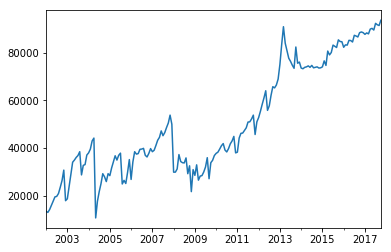

In [37]:
data["lowest_deal_price"].plot() #### looks much better

In [40]:
# build a function to test stationarity 

def check_stationary(ts_data):
    ## visually check
    rol_mean = pd.rolling_mean(ts_data,window=12)
    rol_std = pd.rolling_std(ts_data,window=12)
    plt.figure(figsize=(6,6))
    plt.plot(ts_data,label='original')
    plt.plot(rol_mean,label="rolling mean")
    plt.plot(rol_std,label="rolling std")
    plt.legend()
    ## adfuller test
    result = adfuller(ts_data,autolag="AIC")
    print("---"*5,"ADF TEST RESULT","---"*5,"\n")
    print(" ADF value: ",result[0])
    print(" P_Value: ",result[1])
    print(" Lags used: ", result[2])
    print(" num of obs: ", result[3])
    print("intervals: ", result[4])

    

--------------- ADF TEST RESULT --------------- 

 ADF value:  -0.653855988303
 P_Value:  0.858342686511
 Lags used:  3
 num of obs:  186
intervals:  {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


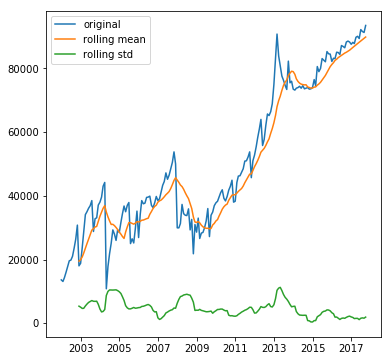

In [41]:
#check stationarity of original data
check_stationary(data["lowest_deal_price"])

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


--------------- ADF TEST RESULT --------------- 

 ADF value:  -1.42856652935
 P_Value:  0.568506957381
 Lags used:  7
 num of obs:  182
intervals:  {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246}


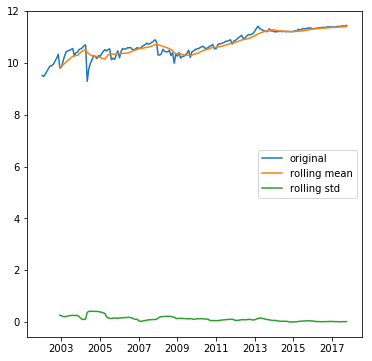

In [42]:
### test result suggests that this is a non-stationary time series data 
## it needs to be transformed or differenced to become stationary before we can apply ARIMA model

## let's try log transformation first

data_log = np.log(data["lowest_deal_price"])
check_stationary(data_log)

--------------- ADF TEST RESULT --------------- 

 ADF value:  -10.2080069086
 P_Value:  5.73617331354e-18
 Lags used:  2
 num of obs:  186
intervals:  {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


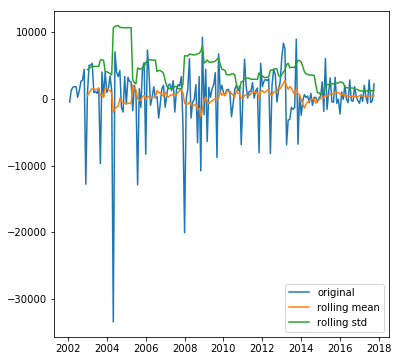

In [44]:
### that's better than the original but still not stationary
### try difference it
data_diff = data["lowest_deal_price"].diff(periods=1).dropna()
check_stationary(data_diff)

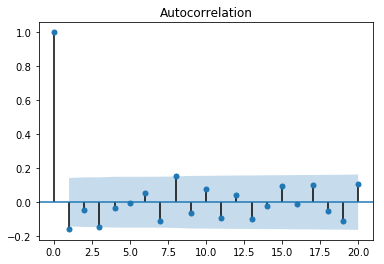

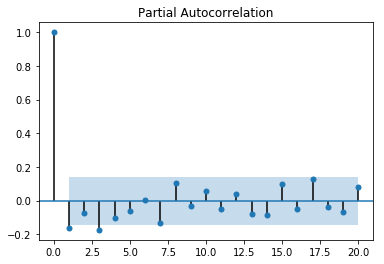

In [45]:
#### This worked very well, Now our data looks like stationary after differencing for 1 order
### now we can plot acf and pacf for model selection

acf_plot = plot_acf(data_diff,lags=20)
pacf_plot = plot_pacf(data_diff,lags=20)

                              ARIMA Model Results                              
Dep. Variable:     D.lowest_deal_price   No. Observations:                  189
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -1852.920
Method:                        css-mle   S.D. of innovations           4378.450
Date:                 Wed, 08 Nov 2017   AIC                           3713.840
Time:                         21:38:42   BIC                           3726.807
Sample:                     02-01-2002   HQIC                          3719.094
                          - 10-01-2017                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       412.5933    163.228      2.528      0.012      92.672     732.515
ar.L1.D.lowest_deal_price     0.5661      0.151      3.747      0.000       0.

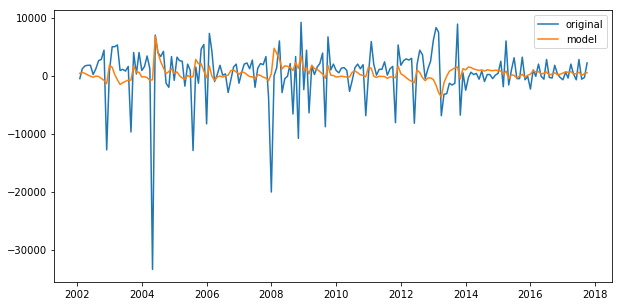

In [72]:
### it suggests that a ARIMA model with p = 1,q =1,d=1

model = ARIMA(data["lowest_deal_price"],order=(1,1,1))
fit = model.fit()
print(fit.summary())
plt.figure(figsize=(10,5))
plt.plot(data_diff,label="original")
plt.plot(fit.fittedvalues,label="model")
plt.legend()

In [73]:
### looks like the model is doing alright, parameters for AR and MA are both statitically significant
### let's bring the fitted values to original scale see how it works 

fitted_values = pd.Series(fit.fittedvalues,copy=True)
fitted_values.head()

2002-02-01    412.593334
2002-03-01    563.103924
2002-04-01    379.741887
2002-05-01    133.783377
2002-06-01    -85.128287
dtype: float64

In [86]:
data_diff_cumsum = fitted_values.cumsum()
start_value = pd.Series(data.iloc[0]["lowest_deal_price"],index=data.index)
model_values = start_value.add(data_diff_cumsum,fill_value=0)
model_values


2002-01-01    13600.000000
2002-02-01    14012.593334
2002-03-01    14575.697258
2002-04-01    14955.439145
2002-05-01    15089.222522
2002-06-01    15004.094235
2002-07-01    14742.634194
2002-08-01    14676.460676
2002-09-01    14549.511539
2002-10-01    14075.921452
2002-11-01    13287.874774
2002-12-01    11911.313517
2003-01-01    13754.401683
2003-02-01    15202.024477
2003-03-01    15439.488459
2003-04-01    14732.354266
2003-05-01    13223.578332
2003-06-01    12032.135491
2003-07-01    11045.469224
2003-08-01    10282.919971
2003-09-01     9523.796976
2003-10-01    11189.629822
2003-11-01    11811.358473
2003-12-01    12411.316328
2004-01-01    12201.133626
2004-02-01    12023.171496
2004-03-01    11720.301563
2004-04-01    10934.084347
2004-05-01    10242.220834
2004-06-01    17041.038743
                  ...     
2015-05-01    81613.264451
2015-06-01    81755.632280
2015-07-01    81831.396607
2015-08-01    81405.010048
2015-09-01    81358.413064
2015-10-01    81608.239539
2

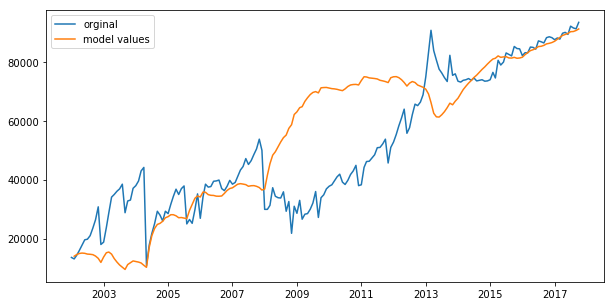

In [75]:
### plot the original scale and values generated by the model
plt.figure(figsize=(10,5))
plt.plot(data["lowest_deal_price"],label="orginal")
plt.plot(model_values,label="model values")
plt.legend()

In [88]:
arima_mse = mean_squared_error(data["lowest_deal_price"],model_values)
arima_mse**0.5

17487.255078110284

In [91]:
decomposition = seasonal_decompose(data["lowest_deal_price"])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

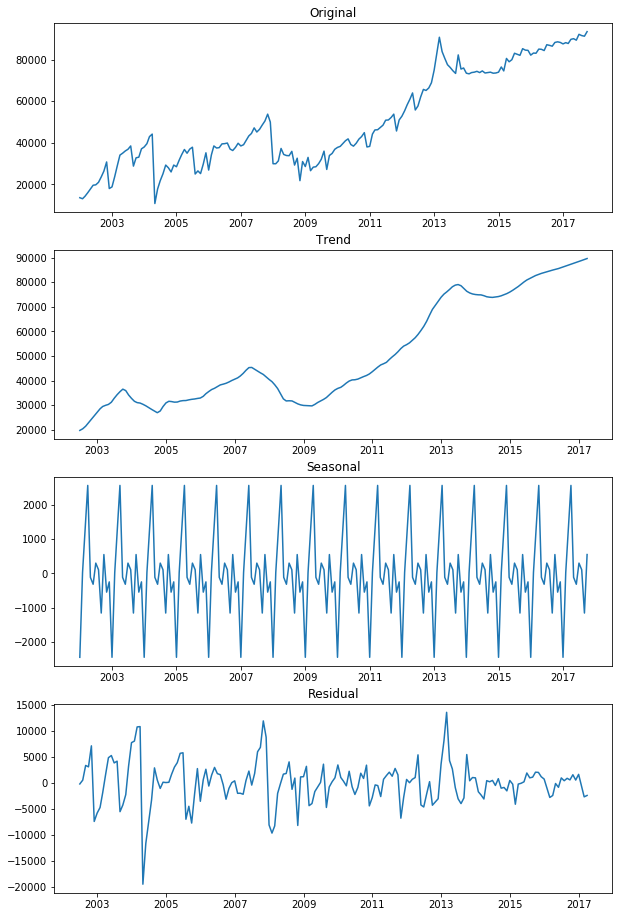

In [94]:
plt.figure(figsize=(10,16))
plt.subplot(411)
plt.plot(data["lowest_deal_price"])
plt.title("Original")
plt.subplot(412)
plt.plot(trend)
plt.title("Trend")
plt.subplot(413)
plt.plot(seasonal)
plt.title("Seasonal")
plt.subplot(414)
plt.plot(residual)
plt.title("Residual")

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


--------------- ADF TEST RESULT --------------- 

 ADF value:  -9.25501304566
 P_Value:  1.45760085604e-15
 Lags used:  3
 num of obs:  174
intervals:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.5757041590698901}


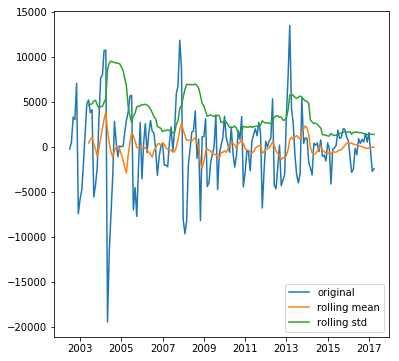

In [96]:
check_stationary(residual.dropna())

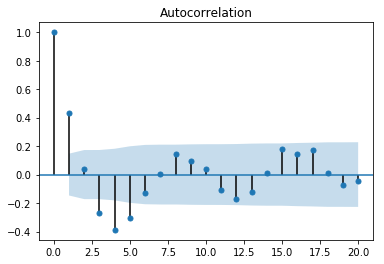

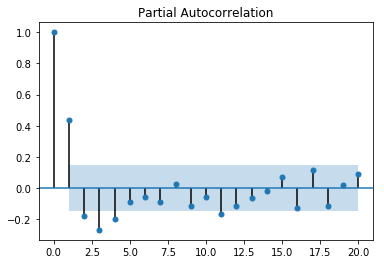

In [100]:
residual = residual.dropna()
resid_acf = plot_acf(residual,lags=20)
resid_pacf = plot_pacf(residual,lags=20)

In [102]:
resid_model = ARIMA(residual,order=(1,1,1))
resid_fit = resid_model.fit()
print(resid_fit.summary())

                              ARIMA Model Results                              
Dep. Variable:     D.lowest_deal_price   No. Observations:                  177
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -1707.710
Method:                        css-mle   S.D. of innovations           3703.940
Date:                 Wed, 08 Nov 2017   AIC                           3423.420
Time:                         22:06:14   BIC                           3436.124
Sample:                     08-01-2002   HQIC                          3428.572
                          - 04-01-2017                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.0080      9.539     -0.210      0.834     -20.705      16.689
ar.L1.D.lowest_deal_price     0.4410      0.068      6.491      0.000       0.

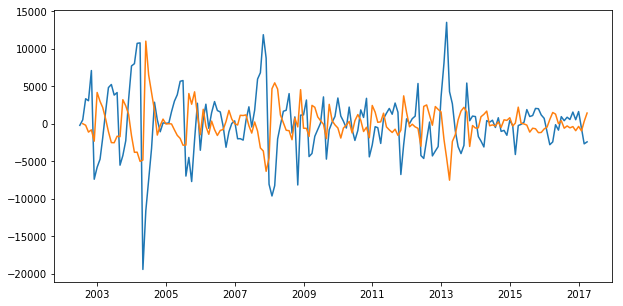

In [104]:
plt.figure(figsize=(10,5))
plt.plot(residual)
plt.plot(resid_fit.fittedvalues)

In [105]:
lr = LinearRegression()
train = data["2002":"2016"]
test = data["2017"]
lr.fit(train[["num_plates","num_bidder"]],train["lowest_deal_price"])
pred = lr.predict(test[["num_plates","num_bidder"]])

In [114]:
pred_train = lr.predict(train[["num_plates","num_bidder"]])

In [115]:
train["pred"] = pred_train

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [109]:
test["pred"] = pred

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


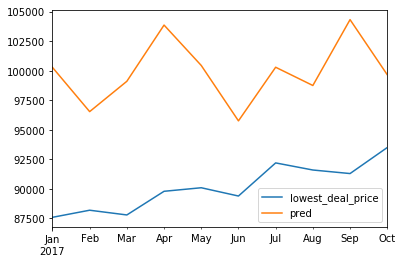

In [112]:
test[["lowest_deal_price","pred"]].plot()

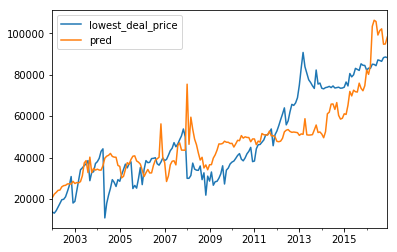

In [116]:
train[["lowest_deal_price","pred"]].plot()

In [117]:
data.corr()

,avg_deal_price,lowest_deal_price,num_bidder,num_plates
avg_deal_price,1.000000,0.992563,0.779555,0.689425
lowest_deal_price,0.992563,1.000000,0.780411,0.700657
num_bidder,0.779555,0.780411,1.000000,0.579912
num_plates,0.689425,0.700657,0.579912,1.000000


In [122]:
rfr = RandomForestRegressor(n_estimators=10)

In [123]:
train = data["2002":"2016"]
test = data["2017"]
rfr.fit(train[["num_plates","num_bidder"]],train["lowest_deal_price"])
rfr_pred = rfr.predict(test[["num_plates","num_bidder"]])

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


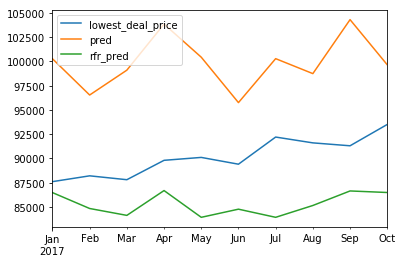

In [127]:
test["pred"] = pred
test["rfr_pred"] = rfr_pred
test[["lowest_deal_price","pred","rfr_pred"]].plot()

In [129]:
rfr_pred_train = rfr.predict(train[["num_plates","num_bidder"]])
train["rfr_pred_train"] = rfr_pred_train

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


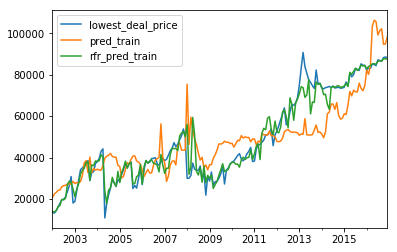

In [135]:

train["pred_train"] = pred_train
train[["lowest_deal_price","pred_train","rfr_pred_train"]].plot()

In [138]:
lr_mse = mean_squared_error(test["lowest_deal_price"],pred)
print(lr_mse**0.5)

10130.8828424


In [139]:
rfr_mse = mean_squared_error(test["lowest_deal_price"],rfr_pred)
print(rfr_mse**0.5)

5262.30557836
